In [2]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Routine for decoding the CIFAR-10 binary file format."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

# Process images of this size. Note that this differs from the original CIFAR
# image size of 32 x 32. If one alters this number, then the entire model
# architecture will change and any model would need to be retrained.
IMAGE_SIZE = 512

# Global constants describing the CIFAR-10 data set.
NUM_CLASSES = 10
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000


def read_cifar10(filename_queue):
    """Reads and parses examples from CIFAR10 data files.

    Recommendation: if you want N-way read parallelism, call this function
    N times.  This will give you N independent Readers reading different
    files & positions within those files, which will give better mixing of
    examples.

    Args:
    filename_queue: A queue of strings with the filenames to read from.

    Returns:
    An object representing a single example, with the following fields:
      height: number of rows in the result (32)
      width: number of columns in the result (32)
      depth: number of color channels in the result (3)
      key: a scalar string Tensor describing the filename & record number
        for this example.
      label: an int32 Tensor with the label in the range 0..9.
      uint8image: a [height, width, depth] uint8 Tensor with the image data
    """

    class CIFAR10Record(object):
        pass
    result = CIFAR10Record()

    # Dimensions of the images in the CIFAR-10 dataset.
    # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
    # input format.
    label_bytes = 1  # 2 for CIFAR-100
    result.height = 32
    result.width = 32
    result.depth = 3
    image_bytes = result.height * result.width * result.depth
    # Every record consists of a label followed by the image, with a
    # fixed number of bytes for each.
    record_bytes = label_bytes + image_bytes

    # Read a record, getting filenames from the filename_queue.  No
    # header or footer in the CIFAR-10 format, so we leave header_bytes
    # and footer_bytes at their default of 0.
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    result.key, value = reader.read(filename_queue)

    # Convert from a string to a vector of uint8 that is record_bytes long.
    record_bytes = tf.decode_raw(value, tf.uint8)

    # The first bytes represent the label, which we convert from uint8->int32.
    result.label = tf.cast(tf.strided_slice(record_bytes, [0], [label_bytes]), tf.int32)

    # The remaining bytes after the label represent the image, which we reshape
    # from [depth * height * width] to [depth, height, width].
    depth_major = tf.reshape(tf.strided_slice(record_bytes, [label_bytes],
                       [label_bytes + image_bytes]),
      [result.depth, result.height, result.width])
    # Convert from [depth, height, width] to [height, width, depth].
    result.uint8image = tf.transpose(depth_major, [1, 2, 0])

    return result


def _generate_image_and_label_batch(image, label, min_queue_examples,
                                    batch_size, shuffle):
    """Construct a queued batch of images and labels.

    Args:
    image: 3-D Tensor of [height, width, 3] of type.float32.
    label: 1-D Tensor of type.int32
    min_queue_examples: int32, minimum number of samples to retain
      in the queue that provides of batches of examples.
    batch_size: Number of images per batch.
    shuffle: boolean indicating whether to use a shuffling queue.

    Returns:
    images: Images. 4D tensor of [batch_size, height, width, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
    """
    # Create a queue that shuffles the examples, and then
    # read 'batch_size' images + labels from the example queue.
    num_preprocess_threads = 16
    if shuffle:
        images, label_batch = tf.train.shuffle_batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size,
            min_after_dequeue=min_queue_examples)
    else:
        images, label_batch = tf.train.batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size)

    # Display the training images in the visualizer.
    tf.summary.image('images', images)

    return images, tf.reshape(label_batch, [batch_size])


def distorted_inputs(data_dir, batch_size):
    """Construct distorted input for CIFAR training using the Reader ops.

    Args:
    data_dir: Path to the CIFAR-10 data directory.
    batch_size: Number of images per batch.

    Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
    """
    filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i)
               for i in xrange(1, 6)]
    for f in filenames:
        if not tf.gfile.Exists(f):
            raise ValueError('Failed to find file: ' + f)

    # Create a queue that produces the filenames to read.
    filename_queue = tf.train.string_input_producer(filenames)

    with tf.name_scope('data_augmentation'):
        # Read examples from files in the filename queue.
        read_input = read_cifar10(filename_queue)
        reshaped_image = tf.cast(read_input.uint8image, tf.float32)

        height = IMAGE_SIZE
        width = IMAGE_SIZE

        # Image processing for training the network. Note the many random
        # distortions applied to the image.

        # Randomly crop a [height, width] section of the image.
        distorted_image = tf.random_crop(reshaped_image, [height, width, 3])

        # Randomly flip the image horizontally.
        distorted_image = tf.image.random_flip_left_right(distorted_image)

        # Because these operations are not commutative, consider randomizing
        # the order their operation.
        # NOTE: since per_image_standardization zeros the mean and makes
        # the stddev unit, this likely has no effect see tensorflow#1458.
        distorted_image = tf.image.random_brightness(distorted_image,
                                                     max_delta=63)
        distorted_image = tf.image.random_contrast(distorted_image,
                                                   lower=0.2, upper=1.8)

        # Subtract off the mean and divide by the variance of the pixels.
        float_image = tf.image.per_image_standardization(distorted_image)

        # Set the shapes of tensors.
        float_image.set_shape([height, width, 3])
        read_input.label.set_shape([1])

        # Ensure that the random shuffling has good mixing properties.
        min_fraction_of_examples_in_queue = 0.4
        min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN *
                                 min_fraction_of_examples_in_queue)
        print ('Filling queue with %d CIFAR images before starting to train. '
               'This will take a few minutes.' % min_queue_examples)

    # Generate a batch of images and labels by building up a queue of examples.
    return _generate_image_and_label_batch(float_image, read_input.label,
                                         min_queue_examples, batch_size,
                                         shuffle=True)


def inputs(eval_data, data_dir, batch_size):
    """Construct input for CIFAR evaluation using the Reader ops.

    Args:
    eval_data: bool, indicating if one should use the train or eval data set.
    data_dir: Path to the CIFAR-10 data directory.
    batch_size: Number of images per batch.

    Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
    """
    if not eval_data:
        filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i)
                     for i in xrange(1, 6)]
        num_examples_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN
    else:
        filenames = [os.path.join(data_dir, 'test_batch.bin')]
        num_examples_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_EVAL

    for f in filenames:
        if not tf.gfile.Exists(f):
            raise ValueError('Failed to find file: ' + f)

    with tf.name_scope('input'):
        # Create a queue that produces the filenames to read.
        filename_queue = tf.train.string_input_producer(filenames)

        # Read examples from files in the filename queue.
        read_input = read_cifar10(filename_queue)
        reshaped_image = tf.cast(read_input.uint8image, tf.float32)

        height = IMAGE_SIZE
        width = IMAGE_SIZE

        # Image processing for evaluation.
        # Crop the central [height, width] of the image.
        resized_image = tf.image.resize_image_with_crop_or_pad(reshaped_image,
                                                               height, width)

        # Subtract off the mean and divide by the variance of the pixels.
        float_image = tf.image.per_image_standardization(resized_image)

        # Set the shapes of tensors.
        float_image.set_shape([height, width, 3])
        read_input.label.set_shape([1])

        # Ensure that the random shuffling has good mixing properties.
        min_fraction_of_examples_in_queue = 0.4
        min_queue_examples = int(num_examples_per_epoch *
                                 min_fraction_of_examples_in_queue)

    # Generate a batch of images and labels by building up a queue of examples.
    return _generate_image_and_label_batch(float_image, read_input.label,
                                         min_queue_examples, batch_size,
                                         shuffle=False)

In [ ]:
def read_labeled_image_list(image_list_file):
    """Reads a .txt file containing pathes and labeles
    Args:
       image_list_file: a .txt file with one /path/to/image per line
       label: optionally, if set label will be pasted after each line
    Returns:
       List with all filenames in file image_list_file
    """
    f = open(image_list_file, 'r')
    filenames = []
    labels = []
    for line in f:
        filename, label = line[:-1].split(' ')
        filenames.append(filename)
        labels.append(int(label))
    return filenames, labels

def read_images_from_disk(input_queue):
    """Consumes a single filename and label as a ' '-delimited string.
    Args:
      filename_and_label_tensor: A scalar string tensor.
    Returns:
      Two tensors: the decoded image, and the string label.
    """
    label = input_queue[1]
    file_contents = tf.read_file(input_queue[0])
    example = tf.image.decode_png(file_contents, channels=3)
    return example, label

# Reads pathes of images together with their labels
image_list, label_list = read_labeled_image_list(filename)

images = ops.convert_to_tensor(image_list, dtype=dtypes.string)
labels = ops.convert_to_tensor(label_list, dtype=dtypes.int32)

# Makes an input queue
input_queue = tf.train.slice_input_producer([images, labels],
                                            num_epochs=num_epochs,
                                            shuffle=True)

image, label = read_images_from_disk(input_queue)

# Optional Preprocessing or Data Augmentation
# tf.image implements most of the standard image augmentation
image = preprocess_image(image)
label = preprocess_label(label)

# Optional Image and Label Batching
image_batch, label_batch = tf.train.batch([image, label],
                                          batch_size=batch_size)

In [2]:
import tensorflow as tf

def shuffle_queue_batch(image, label, batch_size, capacity, min_after_dequeue, threads):
    tensor_list = [image, label]
    dtypes = [tf.float32, tf.int32]
    shapes = [image.get_shape(), label.get_shape()]
    q = tf.RandomShuffleQueue(capacity=capacity, min_after_dequeue=min_after_dequeue,
                              dtypes=dtypes, shapes=shapes)
    enqueue_op = q.enqueue(tensor_list)
    # add to the queue runner
    tf.train.add_queue_runner(tf.train.QueueRunner(q, [enqueue_op] * threads))
    # now extract the batch
    image_batch, label_batch = q.dequeue_many(batch_size)
    return image_batch, label_batch

In [5]:
def queue_run(image, label):
    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        for i in range(5):
            image_batch, label_batch = sess.run([image, label])
            print(image_batch.shape, label_batch.shape)

        coord.request_stop()
        coord.join(threads)

In [28]:
def read_data(file_q):
    # Code from https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10_input.py
    class ImageRecord(object):
        pass

    result = ImageRecord()

    # Dimensions of the images in the CIFAR-10 dataset.
    # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
    # input format.
    label_bytes = 1  # 2 for CIFAR-100
    result.height = 512
    result.width = 512
    result.depth = 3
    image_bytes = result.height * result.width * result.depth
    # Every record consists of a label followed by the image, with a
    # fixed number of bytes for each.
    record_bytes = label_bytes + image_bytes

    # Read a record, getting filenames from the filename_queue.  No
    # header or footer in the CIFAR-10 format, so we leave header_bytes
    # and footer_bytes at their default of 0.
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    result.key, value = reader.read(file_q)

    # Convert from a string to a vector of uint8 that is record_bytes long.
    record_bytes = tf.decode_raw(value, tf.uint8)

    # The first bytes represent the label, which we convert from uint8->int32.
    result.label = tf.cast(
        tf.strided_slice(record_bytes, [0], [label_bytes]), tf.int32)

    # The remaining bytes after the label represent the image, which we reshape
    # from [depth * height * width] to [depth, height, width].
    depth_major = tf.reshape(
        tf.strided_slice(record_bytes, [label_bytes],
                         [label_bytes + image_bytes]),
        [result.depth, result.height, result.width])
    # Convert from [depth, height, width] to [height, width, depth].
    result.uint8image = tf.transpose(depth_major, [1, 2, 0])

    reshaped_image = tf.cast(result.uint8image, tf.float32)

    height = 512
    width = 512

    # Subtract off the mean and divide by the variance of the pixels.
    float_image = tf.image.per_image_standardization(reshaped_image)

    # Set the shapes of tensors.
    float_image.set_shape([height, width, 3])
    result.label.set_shape([1])

    return float_image, result.label

In [67]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

filename_list = np.load("data/train_labels.pkl")
filename_list.reset_index(level=0, inplace=True)
filename_list.head()

filenames = np.array('./data/new/Mass Train/AllJPEGS' + filename_list.IMAGE_NAME)
labels = filename_list.CLASS.values

class_le = LabelEncoder()
class_le.fit(labels)
labels_vec = class_le.transform(labels)
labels_vec

array([5, 5, 3, ..., 4, 2, 2], dtype=int64)

In [94]:
def create_batches(file_names, labels, size=299, batch_size=32, shuffle=True):
    # create tensors
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    files = tf.convert_to_tensor(file_names, dtype=tf.string)
    
    # create the queue
    file_names_q, label_q = tf.train.slice_input_producer([files, labels])
    
    # read the data
    image_queue = tf.read_file(file_names_q)  # convert filenames to content
    image_queue = tf.image.decode_jpeg(image_queue, channels=3)
    image_queue.set_shape([size, size, 1])
    image_queue = tf.to_float(image_queue)  # convert uint8 to float32
    
    return tf.train.batch([image_queue, label_q], batch_size=batch_size)

In [98]:
X, y = create_batches(filenames, labels_vec)




<tf.Tensor 'batch_5:1' shape=(32,) dtype=int32>

In [36]:
image, label = read_data(file_q)
batch_size = 64
num_threads = 16
min_after_dequeue = 10000
capacity = min_after_dequeue + (num_threads + 1) * batch_size

image_batch, label_batch = tf.train.shuffle_batch([image, label], batch_size, capacity, min_after_dequeue, num_threads=num_threads)


In [4]:
def _generate_image_and_label_batch(image, label, min_queue_examples, batch_size=16, shuffle=True):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    label = tf.convert_to_tensor(label, dtype=tf.int32)
    
    num_preprocess_threads = 16
    if shuffle:
        images, label_batch = tf.train.shuffle_batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size,
            min_after_dequeue=min_queue_examples)
    else:
        images, label_batch = tf.train.batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size)

    return images, tf.reshape(label_batch, [batch_size])

In [ ]:
def create_inputs(data_dir, batch_size=16):
    filenames = ['images_0.npy', 'images_1.npy', 'images_2.npy', 'images_3.npy', 'images_4.npy']
    labelfiles = ['labels_0.npy', 'labels_1.npy', 'labels_2.npy', 'labels_4.npy', 'labels_4.npy']
    
    filename_queue = tf.train.string_input_producer(filenames)
    
    read_input = np.load(os.)
    
    return _generate_image_and_label_batch(image, label, min_queue_examples, batch_size, shuffle=True)

## TF Records

In [8]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

train_data_path = os.path.join('data','train.tfrecords')
test_data_path = os.path.join('data','test.tfrecords')

epochs = 10
batch_size = 64
filename_queue = tf.train.string_input_producer([train_data_path], num_epochs=epochs)

def read_queue(filename_queue, batch_size=batch_size):
    feature = {'image': tf.FixedLenFeature([], tf.string), 
               'label_class': tf.FixedLenFeature([], tf.int64),
               'label_normal': tf.FixedLenFeature([], tf.int64),
               'label_pathology': tf.FixedLenFeature([], tf.int64),
               'label_type': tf.FixedLenFeature([], tf.int64),
              }
    
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(serialized_example, features=feature)

    #Convert the image data from string back to the numbers
    image = tf.decode_raw(features['image'], tf.uint8)
    
    # scale the image
    image = tf.to_float(image)
    image = tf.divide(tf.subtract(image, 128), 255.0)
    
    # Cast label data into int32
    label = tf.cast(features['label_class'], tf.int64)
    
    # Reshape image data into the original shape
    image = tf.reshape(image, [299, 299, 1])
    
    images, labels = tf.train.shuffle_batch([image, label], batch_size=batch_size, capacity=30, num_threads=1, min_after_dequeue=10)
    
    return images, labels

In [9]:
X, y = read_queue(filename_queue)
print(X.shape)
print(y.shape)

(64, 299, 299, 1)
(64,)


(64, 299, 299, 1)


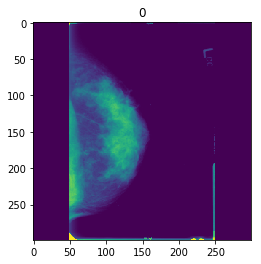

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    img, lab = sess.run([X, y])
    print(img.shape)
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)

img = (img * 255) + 128
plt.imshow(img[39].reshape([299,299]))
plt.title(lab[39])